In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical  # Only for categorical one hot encoding
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
cy_train = np.array(to_categorical(y_train))
cy_test = np.array(to_categorical(y_test))

cx_train, cx_test = np.array((x_train.reshape(x_train.shape[0], 28, 28, 1) - 127.5)/127.5), np.array((x_test.reshape(x_test.shape[0], 28, 28, 1)-127.5)/127.5)
cx_train.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # total_loss = tf.concat((fake_loss, real_loss), axis=0)
    total_loss = (fake_loss + real_loss) * 0.5
    return total_loss #* 0.5
    
def wasserstein_discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(real_output - fake_output)
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output) * 0.9, fake_output)

def wasserstein_generator_loss(fake_output):
    total_loss = -tf.reduce_mean(fake_output)
    return total_loss

def generator_enc_loss(real, fake):
  # return tf.reduce_mean(tf.abs(real - fake))
  return tf.keras.losses.mean_absolute_error(real, fake)

In [ ]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, use_bias=False, input_shape=(128,)))
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (7, 7), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def discriminator():
    inputLayer = layers.Input((28, 28, 1))
    x = tf.keras.layers.GaussianNoise(0.05)(inputLayer)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)
    print(x.shape)
    x = layers.GlobalAveragePooling2D()(x)
    encOut = x
    x = layers.Dense(1, activation='sigmoid')(x)

    dis = tf.keras.models.Model(inputs=inputLayer, outputs=x)
    enc = tf.keras.models.Model(inputs=inputLayer, outputs=encOut)

    return dis, enc

In [ ]:
gen = generator()
des, enc = discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

(None, 4, 4, 128)


In [ ]:
def trainDesGenEnc(gen, des, enc, real, batch_size):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    noise = enc(real, training=False)
    fake = gen(noise, training=True)
    X = tf.concat((fake, real), axis=0)
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

    gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainGenEnc(gen, enc, real, batch_size):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    real_enc = enc(real, training=False)
    enc_fake = gen(real_enc, training=True)

    gen_loss = generator_enc_loss(real, enc_fake) * 0.5
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainDes(gen, des, real, batch_size):
  with tf.GradientTape() as disc_tape:
    noise = tf.random.normal([batch_size, 128])

    fake = gen(noise, training=False)

    X = tf.concat((fake, real), axis=0)
    
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output)
    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

# @tf.function
def trainDesGen(gen, des, real, batch_size):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 128])
    fake = gen(noise, training=True)
    X = tf.concat((fake, real), axis=0)
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)

    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainGen(gen, des, batch_size):
  with tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 128])

    fake = gen(noise, training=True)
    fake_output = des(fake, training=False)

    gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

def evalGan(gen, des, data, batches, batch_size):
  desAcc = 0
  genLoss = 0
  for i in range(batches):
    real = data[i]
    fake = gen.predict(tf.random.normal([batch_size, 128]))
    X = tf.concat((fake, real), axis=0)

    output = des.predict(X)

    real_output = output[batch_size:]
    fake_output = output[:batch_size]

    labels = tf.reshape(tf.concat((tf.zeros_like(fake_output), tf.ones_like(real_output)), axis=0), [-1])
    output = tf.reshape(output, [-1])
    
    acc = tf.keras.metrics.binary_accuracy(labels, output, threshold=0.5)
    desAcc += acc.numpy()
    # print(acc)
    genLoss += tf.reduce_sum(generator_loss(fake_output)).numpy()
  return desAcc / batches, genLoss / batches

def trainGan(realData, epochs=10, batch_size=5, loss='mse'):
  realData = realData.reshape(tuple([-1, batch_size] + list(realData.shape[1:])))
  print(realData.shape)
  noise = tf.random.normal([16, 128])
  results = []
  for epoch in range(epochs):
    realData = tf.random.shuffle(realData)
    for iter in range(len(realData)):
      real = realData[iter]
      real = tf.cast(real, tf.float32)

      trainDes(gen, des, real, batch_size)
      trainGen(gen, des, batch_size)
      # trainDesGen(gen, des, real, batch_size)
      # trainGenEnc(gen, enc, real, batch_size)
      # trainDesGenEnc(gen, des, enc, real, batch_size)

    fake = gen.predict(noise)
    print("Evaluating:")
    desAcc, genLoss = evalGan(gen, des, realData, 10, batch_size)
    results.append({'desAcc':desAcc, 'genLoss':genLoss})
    print("Epoch ", epoch, desAcc, genLoss)

    fig = plt.figure(figsize=(4,4))

    for i in range(fake.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(fake[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

(1000, 60, 28, 28, 1)
Evaluating:
Epoch  0 0.8899999976158142 226.65380249023437


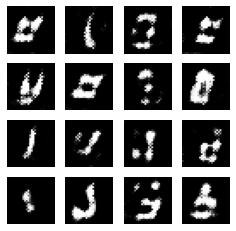

Evaluating:
Epoch  1 0.839166671037674 125.7628662109375


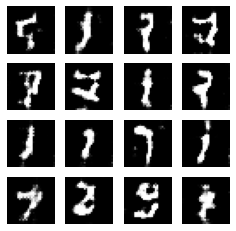

Evaluating:
Epoch  2 0.8833333253860474 87.63165588378907


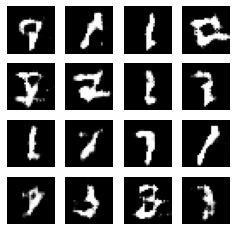

Evaluating:
Epoch  3 0.9216666638851165 95.29544601440429


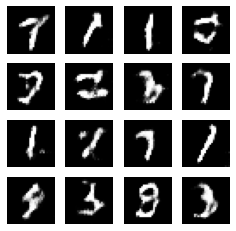

Evaluating:
Epoch  4 0.9041666686534882 118.94480895996094


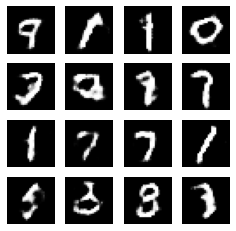

Evaluating:
Epoch  5 0.8933333277702331 102.17150115966797


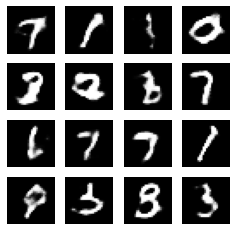

Evaluating:
Epoch  6 0.7741666734218597 65.49281539916993


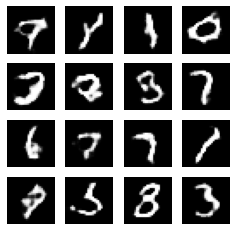

Evaluating:
Epoch  7 0.8008333384990692 68.64881172180176


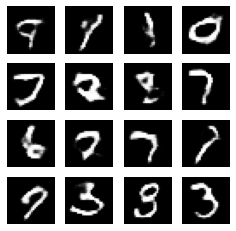

Evaluating:
Epoch  8 0.6924999952316284 45.149855041503905


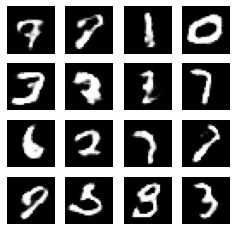

Evaluating:
Epoch  9 0.8183333337306976 76.40059204101563


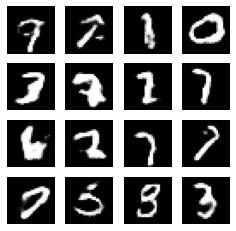

Evaluating:
Epoch  10 0.773333340883255 71.04586830139161


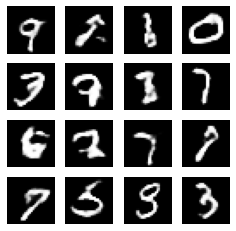

Evaluating:
Epoch  11 0.748333340883255 62.13642616271973


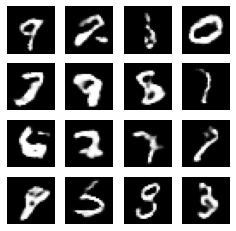

Evaluating:
Epoch  12 0.7991666674613953 109.99653625488281


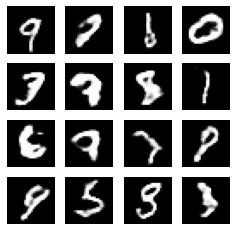

Evaluating:
Epoch  13 0.7816666722297668 61.133399963378906


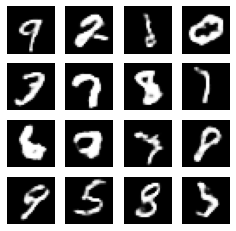

Evaluating:
Epoch  14 0.7741666674613953 75.12004623413085


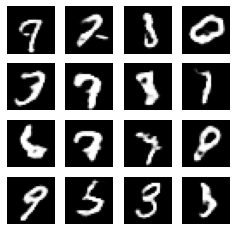

Evaluating:
Epoch  15 0.8175000011920929 89.24254913330078


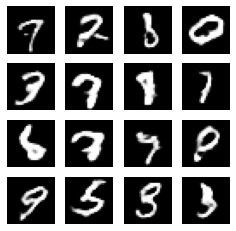

Evaluating:
Epoch  16 0.6525000035762787 154.68034973144532


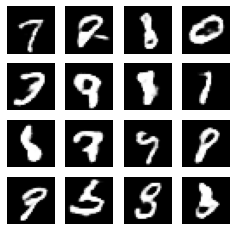

Evaluating:
Epoch  17 0.778333330154419 111.35432357788086


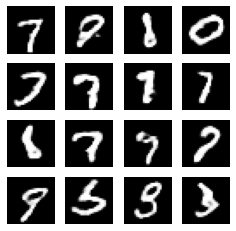

Evaluating:
Epoch  18 0.798333328962326 95.5247932434082


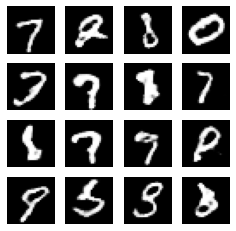

Evaluating:
Epoch  19 0.8283333361148835 92.35744552612304


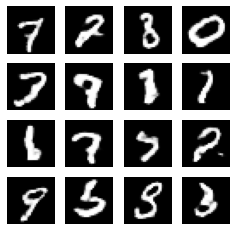

Evaluating:
Epoch  20 0.8058333218097686 94.54797592163087


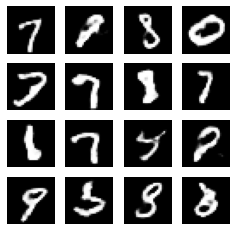

Evaluating:
Epoch  21 0.8416666626930237 81.86052322387695


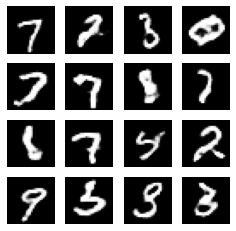

Evaluating:
Epoch  22 0.8166666626930237 77.23389129638672


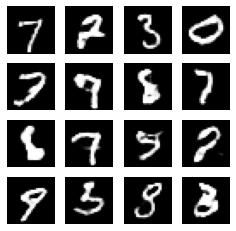

Evaluating:
Epoch  23 0.7291666686534881 51.08172798156738


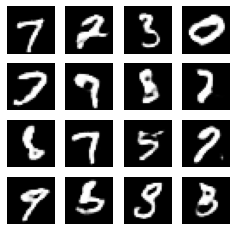

Evaluating:
Epoch  24 0.6316666603088379 40.91738662719727


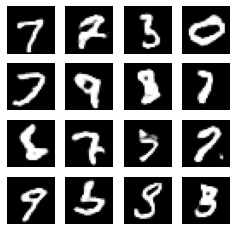

Evaluating:
Epoch  25 0.8024999976158143 74.00296821594239


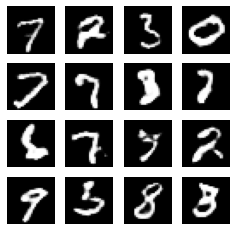

Evaluating:
Epoch  26 0.8283333361148835 72.95257720947265


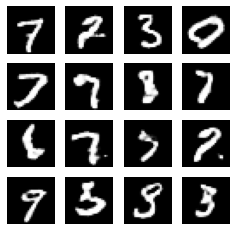

Evaluating:
Epoch  27 0.7983333349227906 89.33381423950195


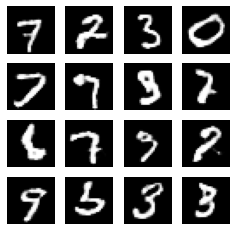

Evaluating:
Epoch  28 0.8175000011920929 118.43008041381836


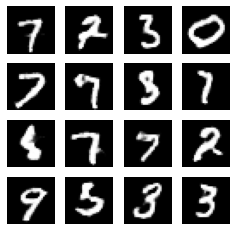

Evaluating:
Epoch  29 0.6883333265781403 159.04217529296875


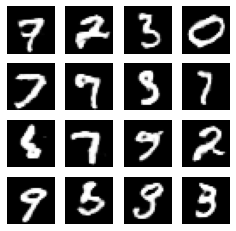

Evaluating:
Epoch  30 0.7233333349227905 50.06789703369141


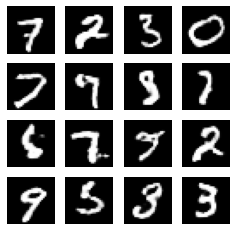

Evaluating:
Epoch  31 0.7741666674613953 142.46674423217775


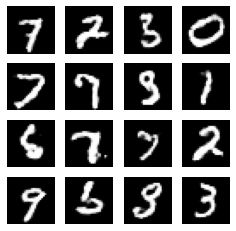

Evaluating:
Epoch  32 0.6675000071525574 42.61443862915039


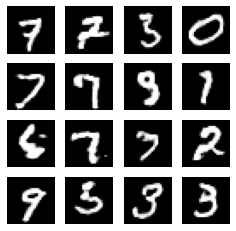

Evaluating:
Epoch  33 0.5558333456516266 231.33206939697266


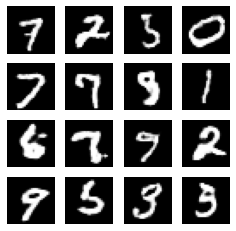

Evaluating:
Epoch  34 0.7091666698455811 165.13019104003905


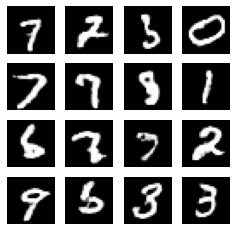

Evaluating:
Epoch  35 0.7566666543483734 151.48228912353517


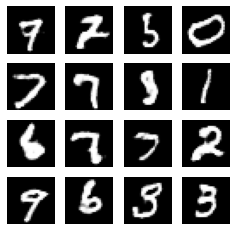

Evaluating:
Epoch  36 0.8349999964237214 113.45715255737305


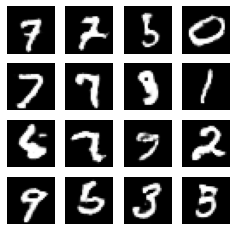

Evaluating:
Epoch  37 0.7708333313465119 180.3056625366211


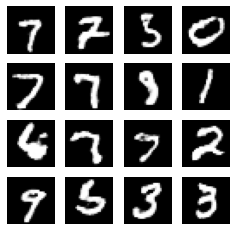

Evaluating:
Epoch  38 0.7974999964237213 146.47608795166016


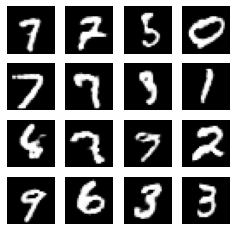

Evaluating:
Epoch  39 0.5691666662693023 34.35204849243164


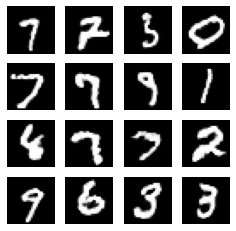

Evaluating:
Epoch  40 0.7900000095367432 64.77513885498047


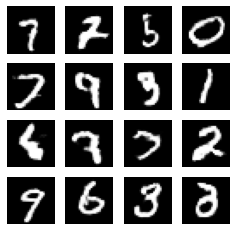

Evaluating:
Epoch  41 0.6524999976158142 40.430718994140626


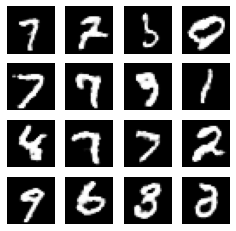

Evaluating:
Epoch  42 0.8866666674613952 120.39147338867187


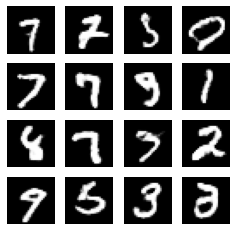

Evaluating:
Epoch  43 0.7324999928474426 64.75751190185547


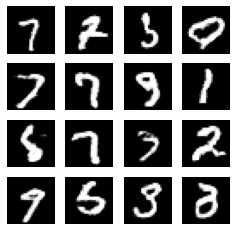

Evaluating:
Epoch  44 0.8441666662693024 111.69742813110352


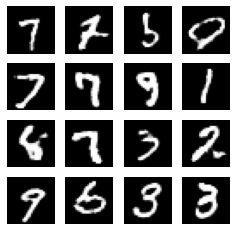

Evaluating:
Epoch  45 0.8100000023841858 103.57986068725586


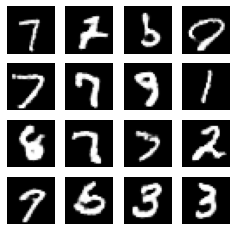

Evaluating:
Epoch  46 0.7875 63.01046371459961


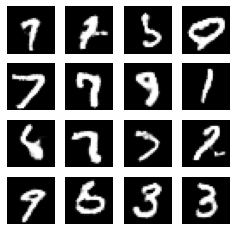

Evaluating:
Epoch  47 0.8575000107288361 72.09065399169921


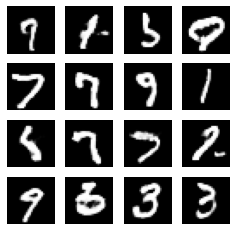

Evaluating:
Epoch  48 0.8625000059604645 144.00501098632813


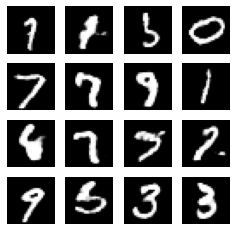

Evaluating:
Epoch  49 0.8658333361148834 89.13827667236328


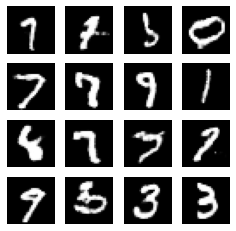

Evaluating:
Epoch  50 0.8083333313465119 159.84417572021485


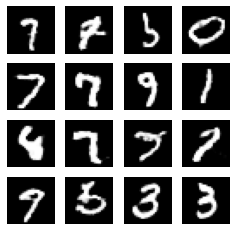

Evaluating:
Epoch  51 0.8375000059604645 175.3414291381836


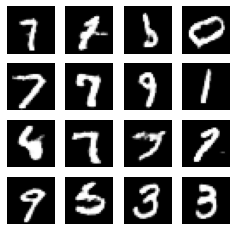

Evaluating:
Epoch  52 0.8291666626930236 73.00428848266601


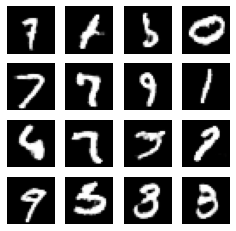

Evaluating:
Epoch  53 0.8858333349227905 105.07371597290039


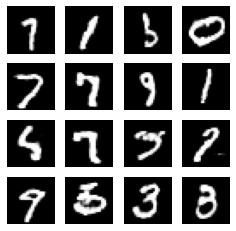

Evaluating:
Epoch  54 0.8758333325386047 156.52301177978515


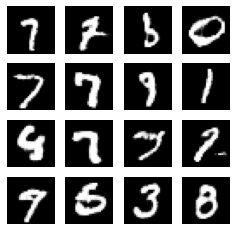

Evaluating:
Epoch  55 0.903333330154419 111.0676383972168


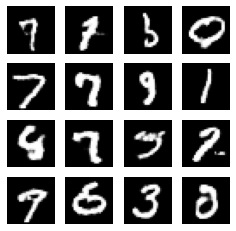

Evaluating:
Epoch  56 0.7258333325386047 200.46612091064452


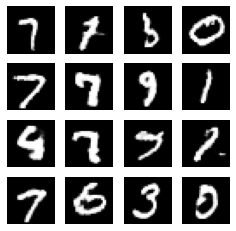

Evaluating:
Epoch  57 0.6700000047683716 234.6625717163086


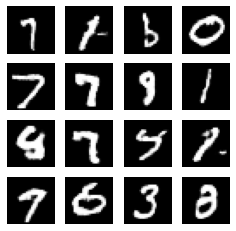

Evaluating:
Epoch  58 0.7908333301544189 77.62945556640625


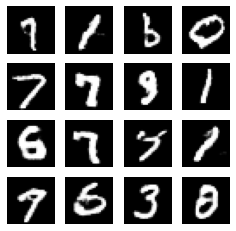

Evaluating:
Epoch  59 0.6200000047683716 262.1008499145508


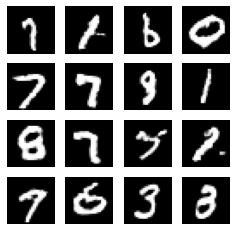

Evaluating:
Epoch  60 0.7116666615009308 48.62537536621094


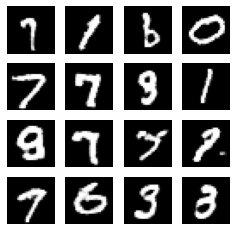

Evaluating:
Epoch  61 0.8133333325386047 164.8642135620117


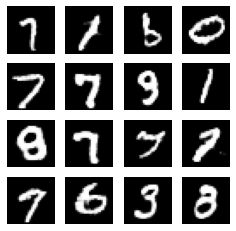

Evaluating:
Epoch  62 0.639166671037674 278.0592376708984


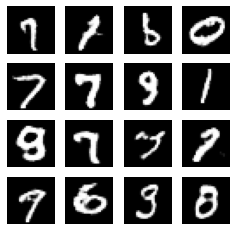

Evaluating:
Epoch  63 0.5841666698455811 321.8601531982422


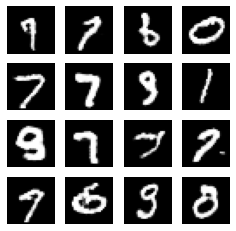

Evaluating:
Epoch  64 0.8291666626930236 82.4718734741211


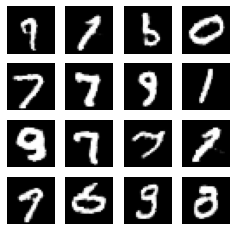

Evaluating:
Epoch  65 0.8258333265781402 78.51618728637695


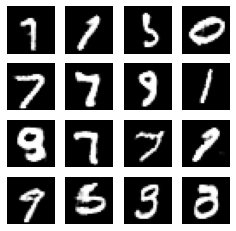

Evaluating:
Epoch  66 0.9041666626930237 124.78918991088867


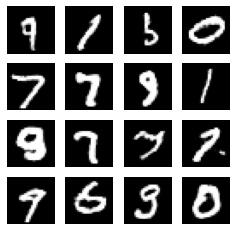

Evaluating:
Epoch  67 0.8491666674613952 171.40423583984375


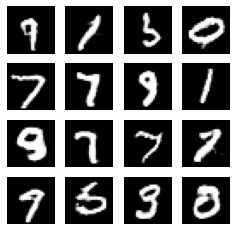

Evaluating:
Epoch  68 0.7908333361148834 172.6224380493164


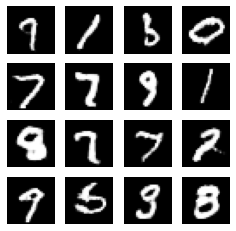

Evaluating:
Epoch  69 0.8033333361148834 225.30167388916016


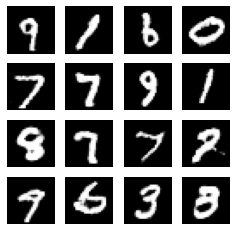

Evaluating:
Epoch  70 0.9050000071525574 158.06316680908202


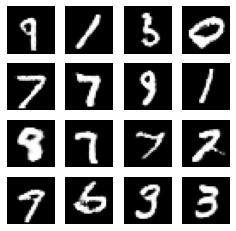

Evaluating:
Epoch  71 0.6183333396911621 263.28754272460935


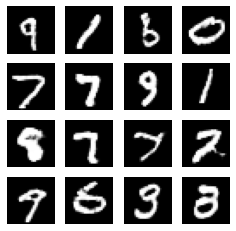

Evaluating:
Epoch  72 0.7816666603088379 214.64715423583985


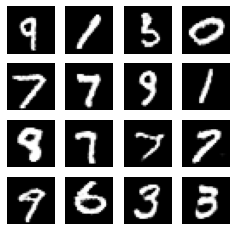

Evaluating:
Epoch  73 0.7449999928474427 229.3188674926758


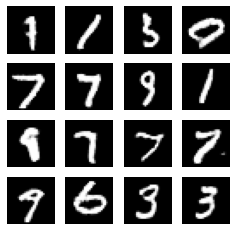

Evaluating:
Epoch  74 0.7708333313465119 198.8819320678711


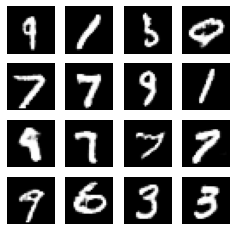

Evaluating:
Epoch  75 0.603333342075348 271.31471862792966


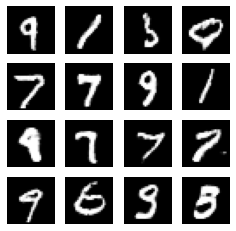

Evaluating:
Epoch  76 0.7624999940395355 239.65234832763673


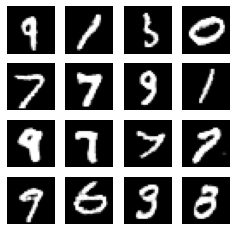

Evaluating:
Epoch  77 0.9475000083446503 125.56430358886719


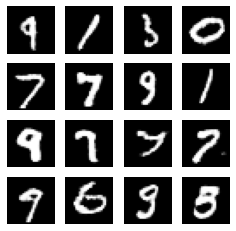

Evaluating:
Epoch  78 0.9200000047683716 110.88742599487304


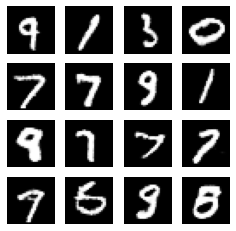

Evaluating:
Epoch  79 0.6391666650772094 40.3990592956543


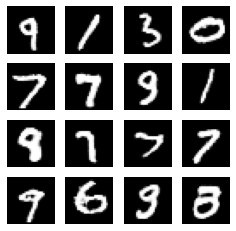

Evaluating:
Epoch  80 0.5541666746139526 370.26136779785156


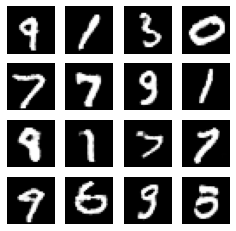

Evaluating:
Epoch  81 0.6875000059604645 271.2687591552734


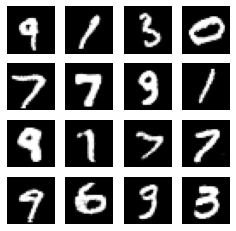

Evaluating:
Epoch  82 0.6775000035762787 252.94872131347657


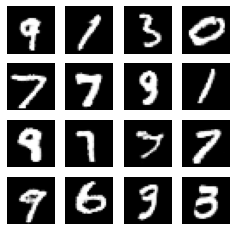

Evaluating:
Epoch  83 0.8725000083446502 183.9365997314453


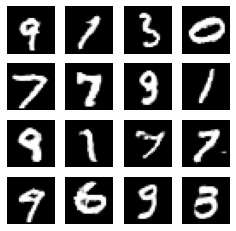

Evaluating:
Epoch  84 0.9025000035762787 124.01385345458985


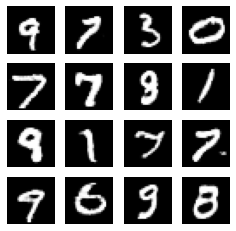

Evaluating:
Epoch  85 0.8200000047683715 221.04092864990236


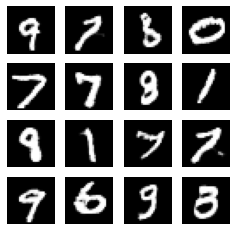

Evaluating:
Epoch  86 0.5675000011920929 359.82383117675784


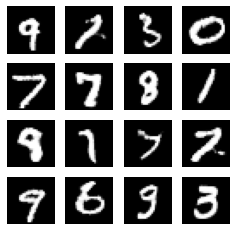

Evaluating:
Epoch  87 0.8383333384990692 218.5495346069336


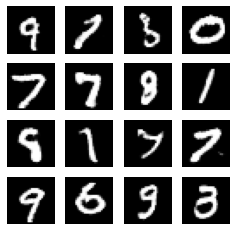

Evaluating:
Epoch  88 0.7416666567325592 260.74310607910155


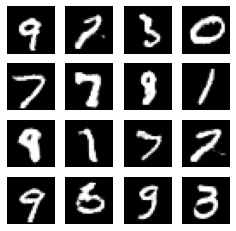

Evaluating:
Epoch  89 0.784166669845581 70.4963005065918


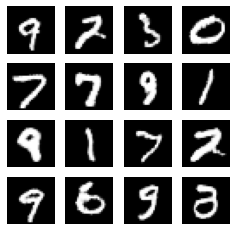

Evaluating:
Epoch  90 0.5741666615009308 33.47857494354248


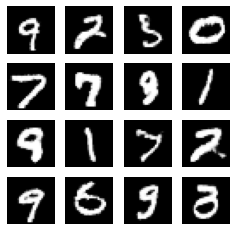

Evaluating:
Epoch  91 0.5475000023841858 31.482096099853514


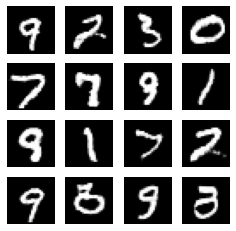

Evaluating:
Epoch  92 0.7724999964237214 72.04367446899414


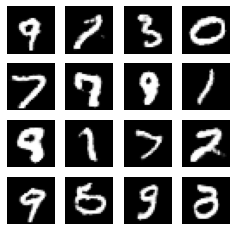

Evaluating:
Epoch  93 0.9316666662693024 136.13482513427735


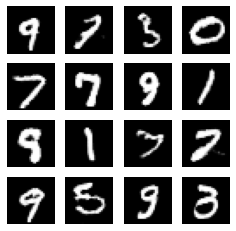

Evaluating:
Epoch  94 0.9066666722297668 130.3728874206543


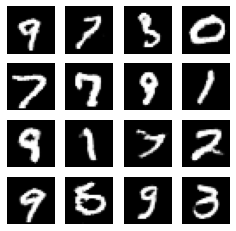

Evaluating:
Epoch  95 0.903333330154419 154.83135833740235


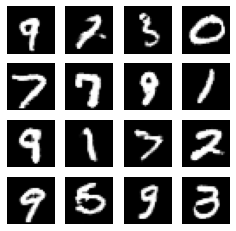

Evaluating:
Epoch  96 0.9025000035762787 110.05175170898437


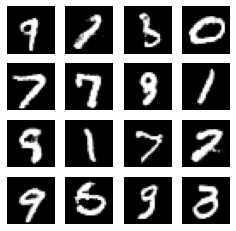

Evaluating:
Epoch  97 0.5433333337306976 445.10194091796876


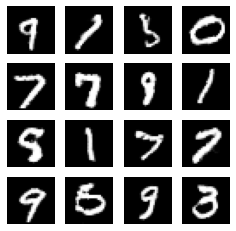

Evaluating:
Epoch  98 0.803333330154419 243.35943298339845


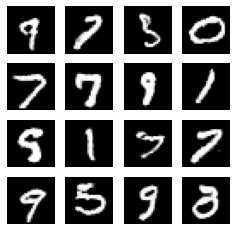

Evaluating:
Epoch  99 0.926666671037674 132.58206100463866


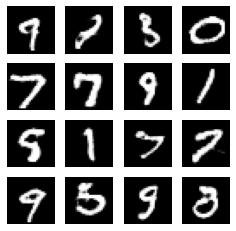

In [ ]:
trainGan(cx_train, epochs=100, batch_size=60)